In [1]:
# Import the necessary Libraries
import torch  #Core PyTorch library for tensors and computations
import torch.nn as nn  #For neural network modules like layers
import torch.nn.functional as F  
import torch.optim as optim  #For optimizers like Adam
from torchvision import datasets, transforms  #To load CIFAR-10 #torchvision.transforms: For data preprocessing.
from torch.utils.data import DataLoader  #To batch and shuffle data
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
#Set Up Device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
#Load and Preprocess the CIFAR-10 Dataset
# Define transformations
transform = transforms.Compose([  #Chains multiple transformations
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std for each channel
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#DataLoader - Batches data (64 images per batch), shuffles training data for randomness

100%|██████████| 170M/170M [00:02<00:00, 57.6MB/s] 


In [4]:
#Prints datasets classes
import torchvision
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
classes = train_dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


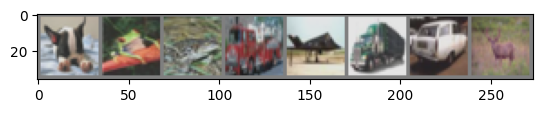

dog frog frog truck airplane truck automobile deer


In [5]:
#Plot a few images to see what the data looks like.
import torchvision.utils as utils  # Import the utils module

def imshow(img):
    img = img / 2.5 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(utils.make_grid(images[:8]))  
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))
# The make_grid function, which arranges multiple images into a grid for visualization, is located in torchvision.utils

In [6]:
#Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() #Defines layers (Conv2d for convolution, MaxPool2d for pooling, Linear for dense layers)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: 3 channels (RGB), Output: 32 filters
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 pooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64 filters
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Flatten and connect to 128 neurons (input size after pooling: 32/4=8)
        self.fc2 = nn.Linear(128, 10)  # Output: 10 classes

    def forward(self, x): #forward: Defines how data flows through the network
        x = self.pool(F.relu(self.conv1(x)))  # Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv -> ReLU -> Pool
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = F.relu(self.fc1(x))  # Fully connected -> ReLU
        x = self.fc2(x)  # Output layer
        return x

# Initialize the model and move to device
model = SimpleCNN().to(device)

In [7]:
#Set Up Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # Loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

In [8]:
#Train the Model
epochs = 10  # Number of epochs; increase for better accuracy but longer training

for epoch in range(epochs):
    model.train()  # Set to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to device
        
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/10, Loss: 1.3484
Epoch 2/10, Loss: 0.9807
Epoch 3/10, Loss: 0.8226
Epoch 4/10, Loss: 0.7083
Epoch 5/10, Loss: 0.6167
Epoch 6/10, Loss: 0.5221
Epoch 7/10, Loss: 0.4413
Epoch 8/10, Loss: 0.3572
Epoch 9/10, Loss: 0.2898
Epoch 10/10, Loss: 0.2251


# Output Interpretation
The loss value (from nn.CrossEntropyLoss) measures how far off your model’s predictions are from the true labels. Lower loss means better predictions.
Each epoch is one full pass through the training dataset (50,000 images in CIFAR-10, batched into groups of 64).
Loss per Epoch: The numbers represent the average loss across all batches in each epoch
* Trend: The loss decreases consistently from 1.3484 in Epoch 1 to 0.2251 in Epoch 10. This is a good sign! It indicates that your model is learning and improving its ability to classify CIFAR-10 images over time.

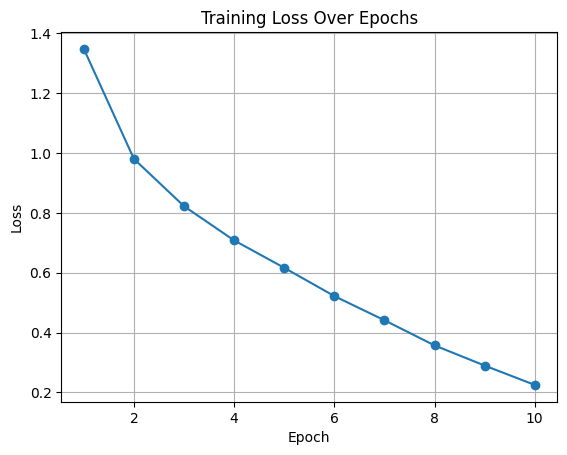

In [10]:
#Visualizing Training Progress
# Store losses during training
losses = [1.3484, 0.9807, 0.8226, 0.7083, 0.6167, 0.5221, 0.4413, 0.3572, 0.2898, 0.2251]

# Create a line chart
plt.plot(range(1, 11), losses, marker='o', linestyle='-', color='#1f77b4')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [12]:
#Evaluate the Model on Test Data
model.eval()  #eval(): Disables training-specific behaviors
correct = 0
total = 0
with torch.no_grad():  # No gradients needed
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Accuracy on test set: 70.47%


# Interpretation of Test Accuracy (70.47%) - model correctly classified 70.47% of the 10,000 images in the CIFAR-10 test set. This means it’s performing reasonably well at distinguishing between the 10 classes (e.g., plane, car, bird) on unseen data. Achieving 70.47% accuracy on the test set with a simple model and only 10 epochs is impressive. It shows the model has learned meaningful patterns (e.g., edges, textures) from the 32x32 RGB images.
# Potential Overfitting - The low training loss (0.2251) compared to a test accuracy of 70.47% suggests the model might be memorizing some training data rather than fully generalizing. This is common with small models and limited regularization.

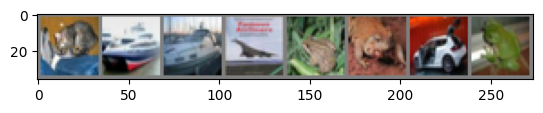

Predicted: cat ship airplane airplane frog frog automobile frog
True:      cat ship ship airplane frog frog automobile frog


In [15]:
# To get a sense of what the model is doing we can visualize some test predictions to see where it succeeds or fails.
# Look for patterns in mistakes like confusing cats with dogs, which are visually similar
import matplotlib.pyplot as plt
import torchvision.utils as utils

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Show images with predicted and true labels
imshow(utils.make_grid(images[:8].cpu()))
print("Predicted:", ' '.join(f'{classes[predicted[j]]}' for j in range(8)))
print("True:     ", ' '.join(f'{classes[labels[j]]}' for j in range(8)))